# Data Cleaning (encoding and removal of rows/features)
Unnamed: 0 - remove

id - remove

url - remove

region - one hot

region_url - remove

price - keep same

year - keep same

manufacturer - one hot

model - one hot

condition - ordinal

cylinders - ordinal

fuel - one hot (gas, diesel)

odometer - keep same

title_status - one hot

transmission - one hot

VIN - remove

drive - one hot

size - one hot

type - one hot

paint_colour - one hot

image_url - remove

description - remove

state - one hot

lat - remove

long - remove

posting_date - dont know?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load in data and remove clearly redundant features

In [2]:
def loadDataSample(samplesize: int, populationsize: int):
    full = pd.read_csv('vehicles.csv', nrows=populationsize) #take 10k rows due to memory limitations
    sample = full.sample(n=samplesize)
    del(full)
    
    #Remove clearly redundant features
    sample = sample.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'image_url', 'VIN', 'description', 'lat', 'long'], axis=1)
    sample.reset_index(drop=True)
    #Unnamed and id columns will have no correlation
    #Url and region url are links to pages that data was scraped from, again obviously no correlation
    #image url, could use computer vision on this but this is outside scope
    
    return sample

def loadDataSet():
    full = pd.read_csv('vehicles.csv')
    
    #Remove clearly redundant features
    full = full.drop(['Unnamed: 0', 'id', 'url', 'region_url', 'image_url', 'VIN', 'description', 'lat', 'long'], axis=1)
    #Unnamed and id columns will have no correlation
    #Url and region url are links to pages that data was scraped from, again obviously no correlation
    #image url, could use computer vision on this but this is outside scope
    
    return full

cars = loadDataSample(10000, 120000)

## Encoding of features

In [3]:
##Some cool encoding wow

## Stats and visualisation

In [4]:
def visualiseMissing(df, detailed: bool, graphical: bool, rank: bool):
    print("Visualing Missing Data")
    missingInFeature = pd.DataFrame(columns=df.columns)
    for feature in df.columns:
        percentEmpty = df[feature].isna().sum()/len(df[feature])*100
        missingInFeature.at["Percentage Missing", feature] = percentEmpty
    missingInFeature = missingInFeature.T
    if rank:
        missingInFeature = missingInFeature.sort_values('Percentage Missing', ascending=False)
        
    if detailed:
        print("Number of Features = ", len(df.columns))
        print("\nPercentage Missing in Features: ")
        display(missingInFeature)

    if graphical:
        #df = pd.DataFrame({'feature':missingInFeature.columns, 'missing':missingInFeature.loc[0]})
        ax = missingInFeature.plot.bar()
        
def visualiseStats(df):
    print("Visualising Statistics")
    display(df.describe())

def visualiseCorr(df, numerical: bool, categorical: bool, detail: bool, bar: bool):
    df_catcodes = df.copy()
    for c in df_catcodes.select_dtypes(exclude='number'):
        df_catcodes[c] = df_catcodes[c].astype('category').cat.codes

    df_pearson = df_catcodes.corr(method='pearson')
    df_kendall = df_catcodes.corr(method='kendall')
    df_spearman = df_catcodes.corr(method='spearman')

    df_pearson.drop(df_pearson.columns.difference(['price']), 1, inplace=True)
    #df_pearson.drop(df_pearson[df_pearson['price'].abs() < 0.015].index)
    df_pearson["pearson abs"] = abs(df_pearson["price"])
    #df_pearson = df_pearson.sort_values('pearson abs', ascending=False)
    df_pearson = df_pearson.rename(columns={'price': 'pearson'})

    df_kendall.drop(df_kendall.columns.difference(['price']), 1, inplace=True)
    #df_kendall.drop(df_kendall[df_kendall['price'].abs() < 0.015].index)
    df_kendall["kendall abs"] = abs(df_kendall["price"])
    #df_kendall = df_kendall.sort_values('kendall abs', ascending=False)
    df_kendall = df_kendall.rename(columns={'price': 'kendall'})

    df_spearman.drop(df_spearman.columns.difference(['price']), 1, inplace=True)
    df_spearman["spearman abs"] = abs(df_spearman["price"])
    #df_spearman = df_spearman.sort_values('spearman abs', ascending=False)
    df_spearman = df_spearman.rename(columns={'price': 'spearman'})

    corrdf = pd.concat([df_pearson, df_kendall, df_spearman], axis=1).drop('price')
    corrdf["Average Abs"] = (corrdf['pearson abs'] + corrdf['kendall abs'] + corrdf['spearman abs'])/3
    corrdf = corrdf.sort_values('Average Abs', ascending=False)
    
    if numerical:
        print("Pearson Correlation for numerical data")
        display(df.corr(method='pearson', min_periods=1))
        plt.matshow(df.corr())
        plt.xticks(range(5), ['price', 'year', 'odometer', 'lat', 'long'])  
        plt.yticks(range(5), ['price', 'year', 'odometer', 'lat', 'long'])
        cb = plt.colorbar()
    
    if categorical:
        f = plt.figure(figsize=(15, 15))
        plt.matshow(df_catcodes.corr(), fignum=f.number)
        plt.xticks(range(df_catcodes.shape[1]), df_catcodes.columns, fontsize=14, rotation=45)
        plt.yticks(range(df_catcodes.shape[1]), df_catcodes.columns, fontsize=14)
        cb = plt.colorbar()
        cb.ax.tick_params(labelsize=14)
        plt.title('Correlation Matrix', fontsize=16);

    
    
    if detail:
        display(corrdf)
    if bar:
        corrdf.drop(columns=['pearson', 'kendall', 'spearman']).plot.bar(figsize=(14,10), title="Correlation with Price")

Visualing Missing Data
Number of Features =  17

Percentage Missing in Features: 


,Percentage Missing
size,69.08
condition,39.21
cylinders,37.46
drive,31.02
paint_color,27.84
type,22.38
odometer,12.83
manufacturer,3.99
model,1.18
title_status,0.55


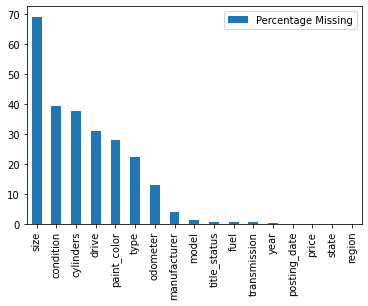

In [5]:
visualiseMissing(cars, detailed=True, graphical=True, rank=True)

## Clean before encoding

In [18]:
from sklearn.linear_model import LinearRegression

def removeOutliers(df, targetFeature, thresholds):
    for i, entry in df.iterrows():
        if thresholds[0] > entry[targetFeature] or entry[targetFeature] > thresholds[1]:
            df.drop([i], inplace=True)
    return df

def NaNtonan(df):
    for i, entry in df.iterrows():
        for feature in df.columns:
            if df.loc[i, feature] == "NaN":
                df.loc[i, feature] = np.nan
    return df
            
def removeRows(df, features):
    df = df.dropna(subset=features)
    return df

def removeFeatures(df, features):
    for feature in features:
        if feature in df.columns:
            df = df.drop(columns=feature)
    return df

def fillFromFeatureMode(df, targetFeature, sampleFeature):
    for i, entry in df[df[targetFeature].isna()].iterrows():
        sample = entry[sampleFeature]
        target = df[df[sampleFeature] == sample][targetFeature].mode()
        if target.empty:
            target = np.nan
        else:
            target = target.values[0]
        df.loc[i, targetFeature] = target
    return df

def fillCondition(df, label, threshold):
    for i, entry in df.iterrows():
        if threshold[0] <= entry['year'] < threshold[1]:
            df.loc[i, 'condition'] = label
    return df
    
def extractCylinderInt(df):
    for i, entry in df.iterrows():
        cylinders = entry['cylinders']
        if cylinders != "other" and type(cylinders) == str:
            df.loc[i, 'cylinders'] = entry['cylinders'].split(' ')[0]
        elif cylinders == "other":
            df.drop(i, inplace=True)
    return df
        
def predictFeature(df, subsetFeature, targetFeature, variableFeature):
    subsets = df[df[targetFeature].isna()][subsetFeature].unique()
    for subset in subsets:
        reg = LinearRegression()
        subsetVehicles = df[df[subsetFeature] == subset]
        trainVehicles = subsetVehicles[subsetVehicles[targetFeature].notna()]
        if len(trainVehicles) > 1:
            x = trainVehicles[variableFeature].values.reshape(-1, 1)
            y = trainVehicles[targetFeature].values.reshape(-1, 1)
            reg.fit(x, y)
            predictVehicles = subsetVehicles[subsetVehicles[targetFeature].isna()]
            predictions = reg.predict(predictVehicles[variableFeature].values.reshape(-1,1))
            j = 0
            for i, entry in predictVehicles.iterrows():
                df.at[i, targetFeature] = predictions[j]
                j += 1
    return df

In [19]:
cars = NaNtonan(cars)

cars = removeOutliers(cars, 'price', [500, 100000])

cars = fillFromFeatureMode(cars, 'fuel', 'model')
cars = fillFromFeatureMode(cars, 'manufacturer', 'model')
cars = fillFromFeatureMode(cars, 'type', 'model')
cars = fillFromFeatureMode(cars, 'size', 'model')
cars = fillFromFeatureMode(cars, 'drive', 'model')
cars = fillFromFeatureMode(cars, 'cylinders', 'model')

cars = fillCondition(cars, 'new', [2018, 2021])
cars = fillCondition(cars, 'like new', [2016, 2018])

#cars = predictFeature(cars, 'model', 'odometer', 'year')

cars = removeRows(cars, ['year', 'transmission', 'title_status', 'manufacturer', 'model', 'fuel', 'odometer', 'type', 'drive', 'cylinders'])

#ENCODING
#cars = extractCylinderInt(cars)
print("Remaining rows:", len(cars))

visualiseMissing(cars, detailed=True, graphical=False, rank=True)

Remaining rows: 6497
Visualing Missing Data
Number of Features =  17

Percentage Missing in Features: 


,Percentage Missing
condition,24.1188
paint_color,20.0092
size,18.0237
region,0
title_status,0
state,0
type,0
drive,0
transmission,0
odometer,0


In [9]:
cars_encoded = pd.get_dummies(cars, columns=['region','manufacturer','model','fuel','title_status','transmission','drive','size','type','paint_color','state'])
cars_encoded.shape

(6517, 1860)